# Regression Discontinuity Analysis on Bank-Debits
## Project Description
Which Debts Are Worth the Bank's Effort? After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. In this project, you will look at a situation where a bank assigned delinquent customers to different recovery strategies based on the expected amount the bank believed it would recover from the customer. The goal for the data scientist is to determine in this non-random assignment whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy. Threshold assignments like this also one occur in medicine (above a certain temperature you get medicine), education (above a certain test score students get admitted to a special class), other areas of finance (above a certain wealth customers get different levels of service), and public sector (below a certain income someone is eligible for housing benefits). Regression discontinuity is an intuitive and useful analysis method in any situation of a threshold assignment.

The goal for the data scientist is to determine in this non-random assignment whether the incremental amount the bank earns exceeded the additional cost of assigning customers to a higher recovery strategy.

## Library's Used

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency, kruskal
import statsmodels.api as sm

## Dataset

In [2]:
data = pd.read_csv('bank_data.csv')
data.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


# Exploratory Data Analysis

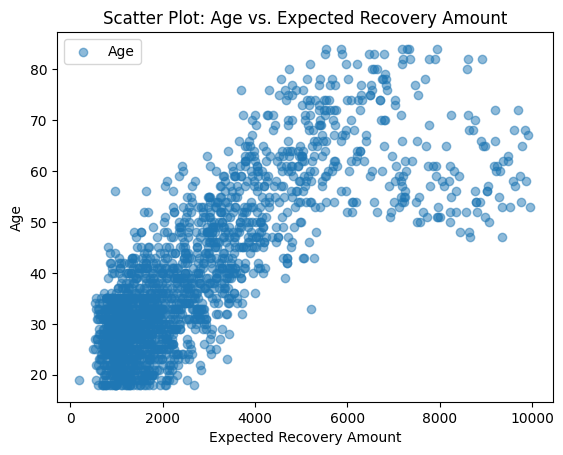

In [3]:
plt.scatter(data['expected_recovery_amount'], data['age'], alpha=0.5, label='Age')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
plt.title('Scatter Plot: Age vs. Expected Recovery Amount')
plt.legend()
plt.show()

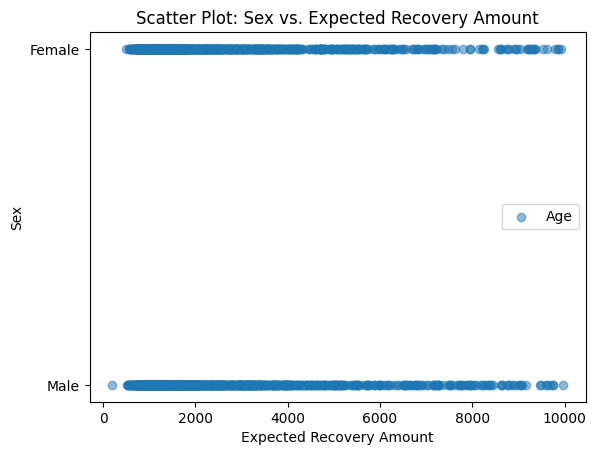

In [4]:
plt.scatter(data['expected_recovery_amount'], data['sex'], alpha=0.5, label='Age')
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Sex')
plt.title('Scatter Plot: Sex vs. Expected Recovery Amount')
plt.legend()
plt.show()

## Statistical Test - Age vs. Expected Recovery Amount:

In [12]:
# Define the threshold
threshold = 1000

# Create two groups based on the threshold
above_threshold = data[data['expected_recovery_amount'] > threshold]['age']
below_threshold = data[data['expected_recovery_amount'] <= threshold]['age']

# Perform a t-test for independent samples
t_statistic, p_value = ttest_ind(above_threshold, below_threshold)

# Print the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Check for statistical significance (common significance level is 0.05)
if p_value < 0.05:
    print("There is a statistically significant difference in average age between the two groups.")
else:
    print("There is no statistically significant difference in average age between the two groups.")

T-statistic: 13.759810322222169
P-value: 4.07177857839181e-41
There is a statistically significant difference in average age between the two groups.


# Statistical Test - Sex vs. Expected Recovery Amount
### Using Fisher Test

In [13]:
from scipy.stats import fisher_exact
# Define the threshold
threshold = 1000

# Create a new column indicating whether the recovery amount is above or below the threshold
data['above_threshold'] = data['expected_recovery_amount'] > threshold

# Create a 2x2 contingency table for males only
contingency_table_male = pd.crosstab(data['sex'] == 'Male', data['above_threshold'])

# Perform Fisher's exact test
odds_ratio, p_value_fisher = fisher_exact(contingency_table_male)

# Print the results
print(f"Odds ratio: {odds_ratio}")
print(f"P-value (Fisher's exact test): {p_value_fisher}")

# Check for statistical significance (common significance level is 0.05)
if p_value_fisher < 0.05:
    print("There is a statistically significant association between being male and recovery amount.")
else:
    print("There is no statistically significant association between being male and recovery amount.")


Odds ratio: 0.8089887640449438
P-value (Fisher's exact test): 0.13293689577964485
There is no statistically significant association between being male and recovery amount.


# Exploratory Graphical Analysis - Recovery Amount

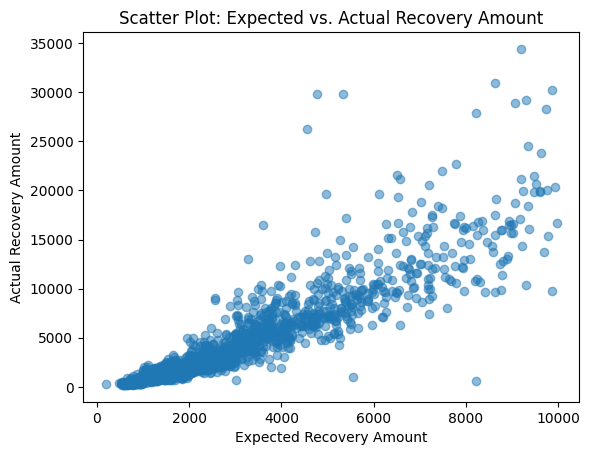

In [15]:

plt.scatter(data['expected_recovery_amount'], data['actual_recovery_amount'], alpha=0.5)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Scatter Plot: Expected vs. Actual Recovery Amount')
plt.show()

# Statistical Analysis - Recovery Amount
### Kruskal-Wallis test

In [16]:
kruskal_stat, p_value_recovery = kruskal(
    data[(data['expected_recovery_amount'] >= 900) & (data['expected_recovery_amount'] <= 1100)]['actual_recovery_amount'],
    data[(data['expected_recovery_amount'] >= 950) & (data['expected_recovery_amount'] <= 1050)]['actual_recovery_amount']
)
print(f'Kruskal-Wallis Statistic for Recovery Amount: {kruskal_stat}, p-value: {p_value_recovery}')


Kruskal-Wallis Statistic for Recovery Amount: 0.823820206138487, p-value: 0.36406558976551284


### Creating two Windows(ranges):
window 1 : 900 to 1100

window 2 : 950 to 1050

These conditions result in two boolean Series (window_1 and window_2) that indicate whether each corresponding row falls within the specified recovery amount ranges.

The Kruskal-Wallis test is then performed separately for each window to examine if there are statistically significant differences in the 'actual_recovery_amount' across different recovery strategies within each specified range.

In [25]:
# Define the windows
window_1 = (900 <= data['actual_recovery_amount']) & (data['actual_recovery_amount'] <= 1100)
window_2 = (950 <= data['actual_recovery_amount']) & (data['actual_recovery_amount'] <= 1050)

# Perform the Kruskal-Wallis test for each window
statistic_1, p_value_1 = kruskal(*[group['actual_recovery_amount'] for name, group in data[window_1].groupby('recovery_strategy')])
statistic_2, p_value_2 = kruskal(*[group['actual_recovery_amount'] for name, group in data[window_2].groupby('recovery_strategy')])

# Print the results for each window
print(f"Kruskal-Wallis statistic (Window 1): {statistic_1}")
print(f"P-value (Window 1): {p_value_1}")

print(f"Kruskal-Wallis statistic (Window 2): {statistic_2}")
print(f"P-value (Window 2): {p_value_2}")

# Check for statistical significance (common significance level is 0.05)
if p_value_1 < 0.05:
    print("There is a statistically significant difference in actual recovery amount across recovery strategies (Window 1).")
else:
    print("There is no statistically significant difference in actual recovery amount across recovery strategies (Window 1).")

if p_value_2 < 0.05:
    print("There is a statistically significant difference in actual recovery amount across recovery strategies (Window 2).")
else:
    print("There is no statistically significant difference in actual recovery amount across recovery strategies (Window 2).")

Kruskal-Wallis statistic (Window 1): 0.888459778659012
P-value (Window 1): 0.6413179717209622
Kruskal-Wallis statistic (Window 2): 0.06278198763175169
P-value (Window 2): 0.9690965882175067
There is no statistically significant difference in actual recovery amount across recovery strategies (Window 1).
There is no statistically significant difference in actual recovery amount across recovery strategies (Window 2).


# Regression Modeling - No Threshold
### OLS Regression

In [18]:
X_no_threshold = sm.add_constant(data['expected_recovery_amount'])
model_no_threshold = sm.OLS(data['actual_recovery_amount'], X_no_threshold).fit()
print(model_no_threshold.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.817
Model:                                OLS   Adj. R-squared:                  0.817
Method:                     Least Squares   F-statistic:                     8378.
Date:                    Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                            16:23:51   Log-Likelihood:                -16936.
No. Observations:                    1882   AIC:                         3.388e+04
Df Residuals:                        1880   BIC:                         3.389e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### Linear Regression 

Mean Squared Error: 4141175.530299501
R-squared: 0.8362344314672197


c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\uti

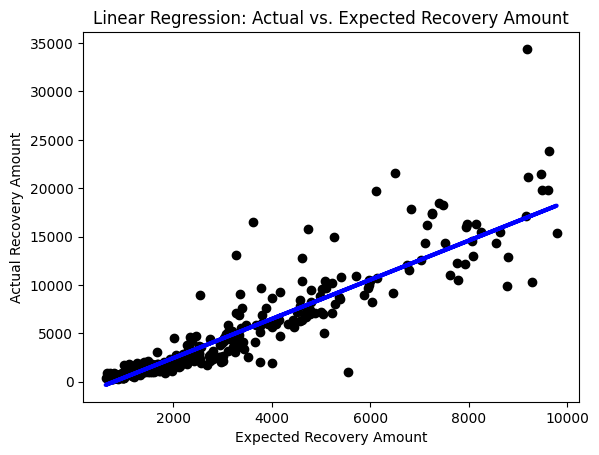

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[['expected_recovery_amount']], data['actual_recovery_amount'], test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Visualize the linear regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Linear Regression: Actual vs. Expected Recovery Amount')
plt.show()


# Regression Modeling - Adding True Threshold
### OLS Regression

In [20]:
data['above_threshold'] = (data['expected_recovery_amount'] > 1000).astype(int)
X_with_threshold = sm.add_constant(data[['expected_recovery_amount', 'above_threshold']])
model_with_threshold = sm.OLS(data['actual_recovery_amount'], X_with_threshold).fit()
print(model_with_threshold.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.819
Model:                                OLS   Adj. R-squared:                  0.818
Method:                     Least Squares   F-statistic:                     4242.
Date:                    Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                            16:23:56   Log-Likelihood:                -16926.
No. Observations:                    1882   AIC:                         3.386e+04
Df Residuals:                        1879   BIC:                         3.387e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### Linear Regression

Mean Squared Error (with threshold): 4094318.061011372
R-squared (with threshold): 0.8380874415707114


c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\uti

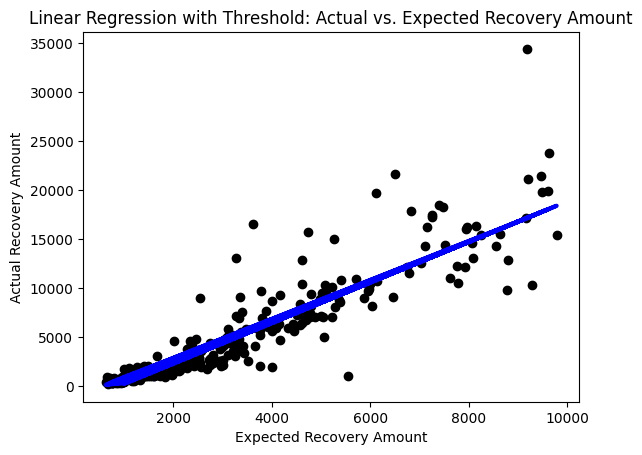

In [21]:
# Add an indicator variable for the true threshold ($1000)
data['above_threshold'] = (data['expected_recovery_amount'] > 1000).astype(int)

# Split the data into training and testing sets
X = data[['expected_recovery_amount', 'above_threshold']]
y = data['actual_recovery_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model_with_threshold = LinearRegression()

# Fit the model to the training data
model_with_threshold.fit(X_train, y_train)

# Make predictions on the test data
y_pred_with_threshold = model_with_threshold.predict(X_test)

# Evaluate the model
mse_with_threshold = mean_squared_error(y_test, y_pred_with_threshold)
r2_with_threshold = r2_score(y_test, y_pred_with_threshold)

print(f'Mean Squared Error (with threshold): {mse_with_threshold}')
print(f'R-squared (with threshold): {r2_with_threshold}')

# Visualize the linear regression line with the threshold
plt.scatter(X_test['expected_recovery_amount'], y_test, color='black')
plt.plot(X_test['expected_recovery_amount'], y_pred_with_threshold, color='blue', linewidth=3)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
plt.title('Linear Regression with Threshold: Actual vs. Expected Recovery Amount')
plt.show()

# Regression Modeling - Adjusting the Window
### OLS Regression

In [22]:

X_adjusted_window = sm.add_constant(
    data[(data['expected_recovery_amount'] >= 950) & (data['expected_recovery_amount'] <= 1050)][['expected_recovery_amount', 'above_threshold']]
)
model_adjusted_window = sm.OLS(
    data[(data['expected_recovery_amount'] >= 950) & (data['expected_recovery_amount'] <= 1050)]['actual_recovery_amount'],
    X_adjusted_window
).fit()
print(model_adjusted_window.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.270
Model:                                OLS   Adj. R-squared:                  0.255
Method:                     Least Squares   F-statistic:                     17.90
Date:                    Mon, 22 Jan 2024   Prob (F-statistic):           2.42e-07
Time:                            16:24:07   Log-Likelihood:                -700.65
No. Observations:                     100   AIC:                             1407.
Df Residuals:                          97   BIC:                             1415.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### Linear Regression

Results for Smaller Window:
Mean Squared Error: 63243.973022500446
R-squared: -0.1271376831418105

Results for Larger Window:
Mean Squared Error: 28707.29005489617
R-squared: 0.23719321456628994


c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Jeevan kishore\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\uti

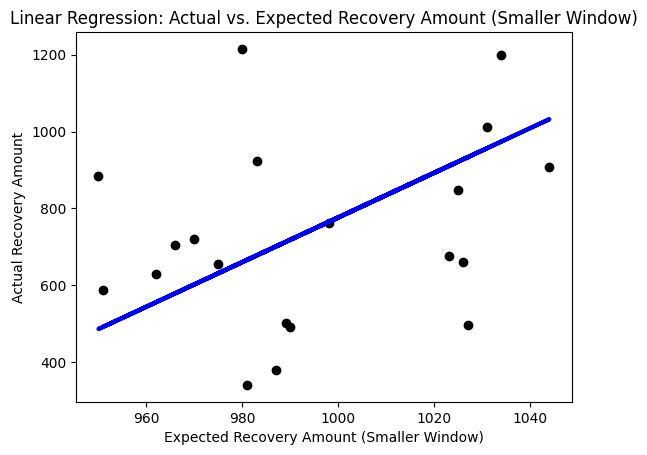

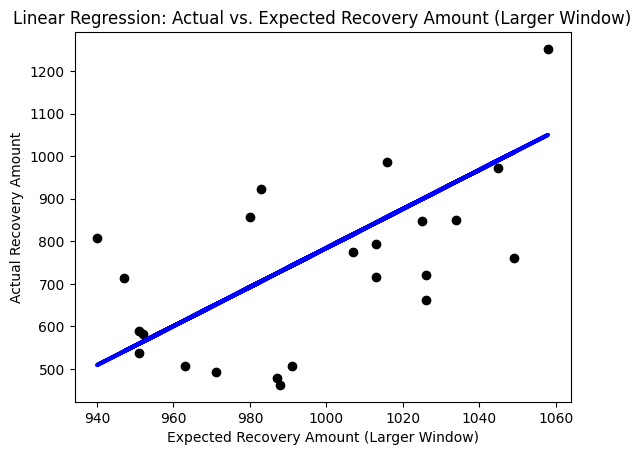

In [23]:
# Define slightly larger and slightly smaller windows
window_smaller = (950 <= data['expected_recovery_amount']) & (data['expected_recovery_amount'] <= 1050)
window_larger = (940 <= data['expected_recovery_amount']) & (data['expected_recovery_amount'] <= 1060)

# Create a linear regression model for the smaller window
X_smaller = data[window_smaller][['expected_recovery_amount']]
y_smaller = data[window_smaller]['actual_recovery_amount']
X_train_smaller, X_test_smaller, y_train_smaller, y_test_smaller = train_test_split(X_smaller, y_smaller, test_size=0.2, random_state=42)

model_smaller = LinearRegression()
model_smaller.fit(X_train_smaller, y_train_smaller)
y_pred_smaller = model_smaller.predict(X_test_smaller)

mse_smaller = mean_squared_error(y_test_smaller, y_pred_smaller)
r2_smaller = r2_score(y_test_smaller, y_pred_smaller)

# Create a linear regression model for the larger window
X_larger = data[window_larger][['expected_recovery_amount']]
y_larger = data[window_larger]['actual_recovery_amount']
X_train_larger, X_test_larger, y_train_larger, y_test_larger = train_test_split(X_larger, y_larger, test_size=0.2, random_state=42)

model_larger = LinearRegression()
model_larger.fit(X_train_larger, y_train_larger)
y_pred_larger = model_larger.predict(X_test_larger)

mse_larger = mean_squared_error(y_test_larger, y_pred_larger)
r2_larger = r2_score(y_test_larger, y_pred_larger)

# Print the results for both windows
print("Results for Smaller Window:")
print(f'Mean Squared Error: {mse_smaller}')
print(f'R-squared: {r2_smaller}')

print("\nResults for Larger Window:")
print(f'Mean Squared Error: {mse_larger}')
print(f'R-squared: {r2_larger}')

# Visualize the linear regression line for the smaller window
plt.scatter(X_test_smaller, y_test_smaller, color='black')
plt.plot(X_test_smaller, y_pred_smaller, color='blue', linewidth=3)
plt.xlabel('Expected Recovery Amount (Smaller Window)')
plt.ylabel('Actual Recovery Amount')
plt.title('Linear Regression: Actual vs. Expected Recovery Amount (Smaller Window)')
plt.show()

# Visualize the linear regression line for the larger window
plt.scatter(X_test_larger, y_test_larger, color='black')
plt.plot(X_test_larger, y_pred_larger, color='blue', linewidth=3)
plt.xlabel('Expected Recovery Amount (Larger Window)')
plt.ylabel('Actual Recovery Amount')
plt.title('Linear Regression: Actual vs. Expected Recovery Amount (Larger Window)')
plt.show()


# Conclusion

As we can see from the above results that the age  factor plays major role rather than gender factor, because there is statistical significance association with the recovery amount.

The smaller window results indicate poorer model performance, as indicated by the negative R-squared value. This may imply that the chosen independent variables or the model itself are not effectively capturing the patterns in the actual recovery amounts for the specified range of expected recovery amounts.

The larger window results show better model performance with a positive R-squared value, indicating that the model explains some of the variability in actual recovery amounts for this broader range of expected recovery amounts.